<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/HystogramsPowerProduction/TurbineParametricModel_PitchCtrl_V14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.ticker as ticker
import pathlib, subprocess
import pandas as pd
from scipy import optimize, interpolate

try:
    __IPYTHON__
    IN_NOTEBOOK = True
except NameError:
    IN_NOTEBOOK = False

def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    # print(output)

if IN_NOTEBOOK:
    import ipywidgets
    cmdcall( 'pip install tdqm' )
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

np.seterr(all='raise');

In [20]:
if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import mpl_utils as mut
from  mpl_utils import linecolors
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [21]:
if not pathlib.Path("Data.xlsx").exists():
  cmdcall( 'curl -O https://raw.githubusercontent.com/joaochenriques/' +
            'IST_MCTE/main/ChannelFlows/HystogramsPowerProduction/Data.xlsx' )

In [22]:
def is_in( a, domain ):
    return domain[0] <= a and a <= domain[1]

def is_out( a, domain ):
    return a < domain[0] or domain[1] < a

# Read stream data velocity

In [23]:
df = pd.read_excel( 'Data.xlsx', 'Sheet1' )
hrs_xls_vec = np.array( df['hrs'] )
U_xls_vec = np.array( df['U'] )

CS = interpolate.CubicSpline( hrs_xls_vec, U_xls_vec, bc_type='clamped' )
t_data_vec = np.linspace( 0, hrs_xls_vec[-1], hrs_xls_vec.size*1200 )
U_data_vec = np.abs( CS( t_data_vec ) )
U_stream_max = np.max( U_data_vec )
f'Maximum tide level = {U_stream_max:.3f} m'

'Maximum tide level = 4.048 m'

# Configuration

In [24]:
# fluid properties
ρ = 1025.0

# Turbine properties
Radius = 8.0
AT = np.pi * Radius**2
I_turb = 1.3E6
Ca = 0.5 * ρ * AT

# velocities
U_cut_in = 0.8
U_cut_out = 3.8

# Powers
P_rated = 700E3

There are a few empirical relation published in the literature which can be written in the generic form as

\begin{equation}
C_P(\mathrm{TSR}, \beta)
=
c_1
\left(
	\frac{c_2}{\mathrm{TSR}_i}
	- c_3 \beta
	- c_4 \beta \, \mathrm{TSR}_i
	- c_5 \beta^{c_0}
	- c_6
\right) \exp\!\left(-\frac{c_7}{\mathrm{TSR}_i}\right)
+ c_8 \mathrm{TSR},
\end{equation}

with

\begin{equation}
	\frac{1}{\mathrm{TSR}_i}
	=
	\frac{1}{\mathrm{TSR}+c_9 \beta}-\frac{c_{10}}{\beta^3+1},
\end{equation}

where $c_i$ are given constants.

See Y.-M. Saint-Drenan, R. Besseau, M. Jansen, I. Staffell, A. Troccoli, et al.,
*A parametric model for wind turbine power curves incorporating environmental conditions*, Renewable Energy, https://doi.org/10.1016/j.renene.2020.04.123

In [25]:
def C_P( TSR, β: float, c: tuple ) -> float:
    TSRi = 1.0 / ( 1.0 / ( TSR + c[9] * β ) - c[10] / ( β**3 + 1 ) )
    cp = c[1] * ( c[2] / TSRi - c[3] * β - c[4] * β * TSRi - c[5] * β**c[0] - c[6] ) * np.exp( -c[7] / TSRi ) + c[8] * TSR
    return cp

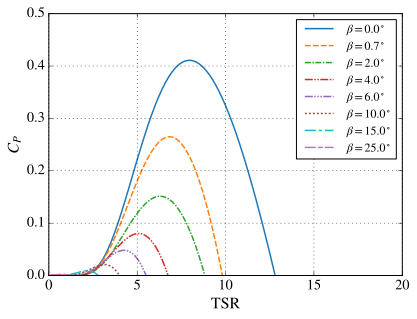

In [26]:
# Turbine models
#             c_0  c_1  c_2  c_3  c_4  c_5  c_6   c_7  c_8   c_9   c_10
c_Ochieng = ( 0.0, 0.5, 116, 0.0, 0.4, 0.0, 5.0, 21.0, 0.0, 0.08, 0.035 )
c_Heier   = ( 0.0, 0.5, 116, 0.4, 0.0, 0.0, 5.0, 21.0, 0.0, 0.08, 0.035 )

TSR_vec = np.linspace( 0.1, 19, 100 )
c_TurbineCoeffs = c_Ochieng
β_space = ( 0, 0.7, 2, 4, 6, 10, 15, 25 )

mpl.figure( figsize=(6, 4.5) )
for β in β_space:
  mpl.plot( TSR_vec, C_P( TSR_vec, β, c_TurbineCoeffs ), label=r'$\beta=%.1f^\circ$' % β )

mpl.legend( loc='upper right', fontsize=12, handlelength=3 )
mpl.grid()
mpl.xlim( 0, 20 )
mpl.ylim( 0, 0.5 )
mpl.xlabel( r'$\mathrm{TSR}$' )
mpl.ylabel( r'$C_P$' )
mpl.savefig( 'TurbineModel.pdf', bbox_inches='tight', pad_inches=0.02 );

# Find the optimal operating point for $\beta=0^\circ$

In [27]:
solution = optimize.minimize_scalar(lambda x: -C_P( x, 0, c_TurbineCoeffs ), bounds=[2,12], method='bounded')
TSR_opt = solution.x
CP_opt = -solution.fun

U_rated  = ( P_rated / ( Ca * CP_opt ) )**(1.0/3.0)

print( f'TSR_opt: {TSR_opt:.3f}' )
print( f'CP_opt: {CP_opt:.3f}' )
print( f'U_rated: {U_rated:.3f}' )

TSR_opt: 7.954
CP_opt: 0.411
U_rated: 2.547


# Operating plots

In [28]:
U_plt_max = np.round( U_cut_out+1,0)

U = np.linspace( 0, U_plt_max, 100 )

P_cut_in = Ca * U_cut_in**3 * CP_opt

P_rated_MW = P_rated / 1E6
P_cut_in_MW = P_cut_in / 1E6
P = 0.5 * ρ * U**3 * AT * CP_opt

P_MW = P / 1E6 # convert to MW
P_MW[ P_MW >= P_rated_MW ] = np.nan
P_MW[ P_MW < P_cut_in_MW ] = np.nan

rated = np.argmax( P_MW > P_rated_MW )
cut_in  = np.argmin( P_MW < P_cut_in_MW )

Uo = np.linspace( U_rated, U_cut_out, 20 )
CPo = P_rated / ( 0.5 * ρ * Uo**3 * AT )

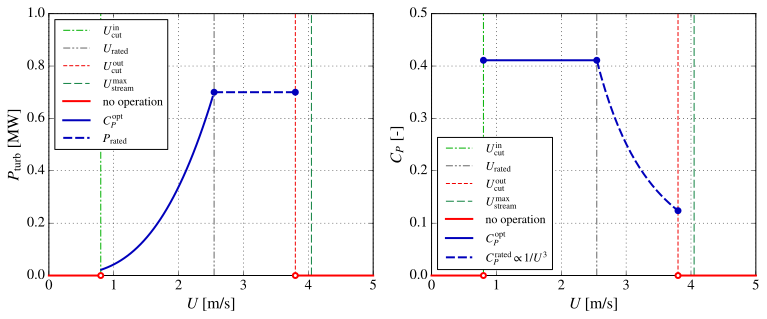

In [29]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.18 )

#=================================
# Plot a)

ax1.axvline( U_cut_in, dashes=(7,2,2,2), color='#00B000', lw=1, label=r'$U_\mathrm{cut}^\mathrm{in}$' )
ax1.axvline( U_rated, dashes=(7,2,2,2,2,2), color='#666666', lw=1, label=r'$U_\mathrm{rated}$' )
ax1.axvline( U_cut_out, dashes=(4,2), color='#F00000', lw=1, label=r'$U_\mathrm{cut}^\mathrm{out}$' )
ax1.axvline( U_stream_max, dashes=(8,3), color='#0e813f', lw=1, label=r'$U_\mathrm{stream}^\mathrm{max}$' )

ax1.plot( (0,U_cut_in), (0,0 ), 'r-', lw=2, clip_on=False, zorder=4 )
ax1.plot( (U_cut_in), (0), 'o', markeredgecolor='r', markerfacecolor='w', markeredgewidth=2, clip_on=False, zorder=4 )

ax1.plot( (U_cut_out,U_plt_max), (0,0 ), 'r-', lw=2, clip_on=False, zorder=4, label='no operation' )
ax1.plot( (U_cut_out), (0), 'o', markeredgecolor='r', markerfacecolor='w', markeredgewidth=2, clip_on=False, zorder=4 )

ax1.plot( U, P_MW, '-', color='#0000BB', lw=2, clip_on=False, zorder=4, label=r'$C_P^\mathrm{opt}$' )
ax1.plot( (U_cut_in,U_rated), (P_MW[cut_in],P_rated_MW), 'o', color='#0000BB', markeredgewidth=2, markeredgecolor='#0000BB', lw=2, zorder=4 )

ax1.set_axisbelow(True)
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(1) )
ax1.plot( (U_rated,U_cut_out), (P_rated_MW,P_rated_MW), lw = 2, dashes=(9,3), color='#0000BB', label=r'$P_\mathrm{rated}$' )
ax1.plot( U_cut_out, P_rated_MW, 'o', color='#0000BB', markeredgewidth=2, markeredgecolor='#0000BB' )

#=================================
# Plot b)

ax1.set_xlim( 0, U_plt_max )
ax1.set_ylim( 0, np.round( P_rated_MW + 0.5, 0 ) )
ax1.legend( loc='upper left', handlelength=2.8, fontsize=12 )
ax1.set_xlabel( r'$U$ [m/s]' )
ax1.set_ylabel( r'$P_\mathrm{turb}$ [MW]' )
ax1.grid()


ax2.set_axisbelow(True)
ax2.set_xlim( 0,U_plt_max )
ax2.axvline( U_cut_in, dashes=(7,2,2,2), color='#00B000', lw=1, label=r'$U_\mathrm{cut}^\mathrm{in}$' )
ax2.axvline( U_rated, dashes=(7,2,2,2,2,2), color='#666666', lw=1, label=r'$U_\mathrm{rated}$' )
ax2.axvline( U_cut_out, dashes=(4,2), color='#F00000', lw=1, label=r'$U_\mathrm{cut}^\mathrm{out}$' )
ax2.axvline( U_stream_max, dashes=(8,3), color='#0e813f', lw=1, label=r'$U_\mathrm{stream}^\mathrm{max}$' )

ax2.plot( (0,U_cut_in), (0,0 ), 'r-', lw=2, clip_on=False, zorder=4, label='no operation' )
ax2.plot( (U_cut_in), (0), 'o', markeredgecolor='r', markerfacecolor='w', markeredgewidth=2, clip_on=False, zorder=4 )

ax2.plot( (U_cut_out,U_plt_max), (0,0 ), 'r-', lw=2, clip_on=False, zorder=4 )
ax2.plot( (U_cut_out), (0), 'o', markeredgecolor='r', markerfacecolor='w', markeredgewidth=2, clip_on=False, zorder=4 )

ax2.plot( (U_cut_in, U_rated), (CP_opt,CP_opt ), '-', color='#0000BB', lw=2, label=r'$C_P^\mathrm{opt}$' )
ax2.plot( (U_cut_in, U_rated), (CP_opt,CP_opt ), 'o', color='#0000BB', markeredgewidth=2, markeredgecolor='#0000BB', lw=2, zorder=4 )

ax2.plot( Uo, CPo, lw = 2, dashes=(9,3), color='#0000BB', label=r'$C_P^\mathrm{rated}\propto 1/U^3$' )
ax2.plot( Uo[-1], CPo[-1], 'o', lw = 2, color='#0000BB', markeredgewidth=2, markeredgecolor='#0000BB' )

ax2.legend( loc='lower left', handlelength=2.8, fontsize=12 )
ax2.set_xlabel( r'$U$ [m/s]' )
ax2.set_ylabel( r'$C_P$ [-]' )
ax2.set_ylim( 0, 0.5 )
ax2.grid()

mpl.savefig( 'TurbineOperation.pdf', bbox_inches='tight', pad_inches=0.02 );

# Computing $\beta$ within $U_\mathrm{rated}$ and $U_\mathrm{cut}^\mathrm{out}$.

## Note that $\Omega=\Omega_\mathrm{rated}$ since $P_\mathrm{gen}=P_\mathrm{turb}=P_\mathrm{gen}^\mathrm{rated}$.


In [30]:
def β_function( β: float, TSR: float, cp: float, c: tuple ) -> float:
    return C_P( TSR, β, c ) - cp

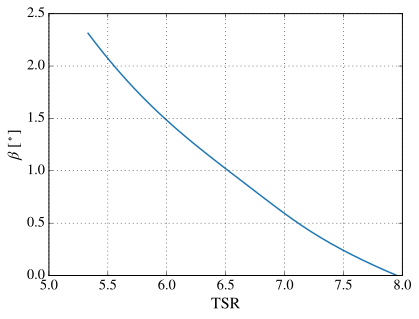

In [31]:
a_gen = Ca * CP_opt * ( Radius / TSR_opt )**3
Ω_rated = ( P_rated / a_gen )**(1.0/3.0)
U_ctrl = np.linspace( U_rated, U_cut_out, 40 )
TSR_ctrl = Ω_rated * Radius / U_ctrl

# Subtract and eps to be lower than CP_opt and do not fail the root finding
CP_ctrl = P_rated / ( Ca * U_ctrl**3 ) - 1E-12

# sort TSR values and CP
ind = np.argsort(TSR_ctrl)
TSR_ctrl = TSR_ctrl[ind]
CP_ctrl = CP_ctrl[ind]

β_ctrl = np.zeros_like( U_ctrl )
for i, ( TSR, CP ) in enumerate( zip( TSR_ctrl, CP_ctrl ) ):
    func = lambda _β: β_function( _β, TSR, CP, c_TurbineCoeffs )
    β_ctrl[i] = optimize.root_scalar(func, bracket=[0,25], method='brentq' ).root

mpl.subplots( figsize=(6, 4.5) )
mpl.plot( TSR_ctrl, β_ctrl, '-' )

mpl.grid()
mpl.xlabel( r'$\mathrm{TSR}$' )
mpl.ylabel( r'$\beta\ [^\circ]$' )
mpl.savefig( 'beta_Pgen_rated.pdf', bbox_inches='tight', pad_inches=0.02 );

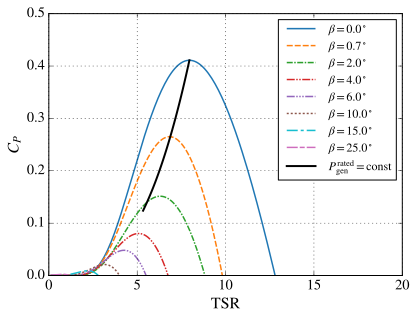

In [32]:
TSR_space = np.linspace( 0.1, 19, 200 )

mpl.figure( figsize=(6, 4.5) )
for β in β_space:
  mpl.plot( TSR_space, C_P( TSR_space, β, c_TurbineCoeffs ), label=r'$\beta=%.1f^\circ$' % β )

mpl.plot( TSR_ctrl, CP_ctrl, 'k-', label=r'$P_\mathrm{gen}^\mathrm{rated}=\mathrm{const}$', linewidth=2 )

mpl.legend( loc='upper right', fontsize=12, handlelength=3 )
mpl.grid()
mpl.xlim( 0, 20 )
mpl.ylim( 0, 0.5 )
mpl.xlabel( r'$\mathrm{TSR}$' )
mpl.ylabel( r'$C_P$' )
mpl.savefig( 'OchiengTurbine.pdf', bbox_inches='tight', pad_inches=0.02 );

# Prepare time integration

In [33]:
n_display = 30

t_vec = np.linspace( 0, t_data_vec[-1], t_data_vec.size//n_display )
U_vec = np.zeros_like( t_vec )

β_vec = np.zeros_like( t_vec )
Ω_vec = np.zeros_like( t_vec )

TSR_vec = np.zeros_like( t_vec )
CP_vec = np.zeros_like( t_vec )

P_turb_MW_vec = np.zeros_like( t_vec )
P_gen_MW_vec = np.zeros_like( t_vec )

tmin = np.round( t_vec[ 0] )
tmax = np.round( t_vec[-1] )
tdelta = ( tmin, tmax )

# time step must be in seconds
Δt = ( t_data_vec[1] - t_data_vec[0] ) * 3600.0
f'Δt = {Δt:.1f} s'

'Δt = 3.0 s'

# Time integration of the turbine model

In [ ]:
TSR_ctrl_domain = ( TSR_ctrl[0], TSR_ctrl[-1] )
t = U = CP = β = P_turb = P_gen = E_turb = E_gen = 0.0
Ω = 0.8
j = 0

Ω_cut_in = 0.5
kappa_Ω = 1.0
kappa_e = 1.0
tau_β = 5

for i in tqdm( range( t_data_vec.size ) ):

    t = t_data_vec[i]
    U = U_data_vec[i]

    TSR = Ω * Radius / np.max( ( U, 0.01 ) )

    if Ω < Ω_cut_in:
        β_des = 0.0
        P_gen = 0.0

    else:
        if Ω < kappa_Ω * Ω_rated:
            β_des = 0
        else:
            e = kappa_e * ( Ω - kappa_Ω * Ω_rated )
            e = np.clip( e, 0, 1 )
            β_des = 25.0 * e

        P_gen = np.min( ( P_rated, a_gen * Ω**3 ) )

    β = β + Δt * ( β_des - β ) / ( tau_β * Δt )
    β = np.clip( β, 1E-6, 25 )
    try:
        CP = C_P( TSR, β, c_TurbineCoeffs )
    except FloatingPointError:
        print( TSR, β, Ω )
        raise

    P_turb = Ca * U**3 * CP

    Ω = Ω + Δt * ( P_turb - P_gen ) / ( Ω * I_turb )
    E_turb = E_turb + Δt * P_turb
    E_gen  = E_gen  + Δt * P_gen

    if i % n_display == 0:
        t_vec[j] = t
        U_vec[j] = U
        Ω_vec[j] = Ω
        β_vec[j] = β
        TSR_vec[j] = TSR
        CP_vec[j] = CP
        P_turb_MW_vec[j] = P_turb / 1E6
        P_gen_MW_vec[j] = P_gen / 1E6
        j += 1

Δt_global = t * 3600
P_turb_mean = E_turb / Δt_global / 1E6
P_gen_mean  = E_gen  / Δt_global / 1E6
CF = P_gen_mean / P_rated_MW

print( f'P_turb_mean: {P_turb_mean:.3f} MW' )
print( f'P_gen_mean:  {P_gen_mean :.3f} MW' )
print( f'CF: {CF:.3f}' )

  0%|          | 0/5264400 [00:00<?, ?it/s]

# Results

In [82]:
mpl.close('all')

def update_U( change ):
    fig, ax = mpl.subplots( 6, 1, figsize = ( 12, 11 ) )
    fig.subplots_adjust( bottom = 0.2, hspace = 0.16 )

    ax[0].plot( t_vec, U_vec, color=linecolors[0] )
    ax[0].set_ylabel( r"$U$ [m/s]" )

    ax[1].plot( t_vec, TSR_vec, color=linecolors[5] )
    ax[1].set_ylabel( "TSR [-]" )

    ax[2].plot( t_vec, CP_vec, color=linecolors[6] )
    ax[2].set_ylabel( r"$C_P$ [-]" )

    ax[3].plot( t_vec, Ω_vec * 30/np.pi, color=linecolors[1] )
    ax[3].set_ylabel( r"$\Omega$ [rpm]" )

    ax[4].plot( t_vec, β_vec, color=linecolors[2] )
    ax[4].set_ylabel( r"$\beta$ [$^\circ$]")

    ax[5].plot( t_vec, P_turb_MW_vec, color=linecolors[3], label=r"$P_\mathrm{turb}$" )
    ax[5].plot( t_vec, P_gen_MW_vec, color=linecolors[4], label=r"$P_\mathrm{gen}$" )
    ax[5].set_ylabel( "Power [MW]" )
    ax[5].legend()

    ax[0].set_yticks( np.arange( 0, 6.01, 2 ) )
    # ax[1].set_yticks( np.arange( 10, 40.01, 10 ) )
    ax[2].set_yticks( np.arange( 0, 0.5, 0.1 ) )
    # ax[3].set_yticks( np.arange( 0, 2.01, 1 ) )
    # ax[4].set_yticks( np.arange( 5, 12, 1 ) )

    P_max = np.round( np.max( P_turb_MW_vec )*1.1, 1 )

    ax[0].set_ylim( 0, 5 )
    ax[1].set_ylim( 5, 10 )
    ax[2].set_ylim( 0, 0.5 )
    ax[5].set_ylim( 0, P_max )

    for i in range( 5 ):
        ax[i].set_xticklabels( [] )
    ax[5].set_xlabel( "time [hour]" )

    for i in range( 6 ):
        ax[i].set_xlim( *change )

    if not IN_NOTEBOOK:
        parent = ax[0]
        for i in range(1,len(ax)):
            ax[i].sharex(parent)
        mpl.tight_layout()

    mpl.savefig('TimeSeries.pdf', bbox_inches = 'tight', pad_inches = 0 ) # pdflatex
    mpl.savefig('TimeSeries.svg', bbox_inches = 'tight', pad_inches = 0 ) # Word

if IN_NOTEBOOK:
    ipywidgets.interact( update_U,
                        change = ipywidgets.FloatRangeSlider(
                                    value = tdelta, \
                                    min = tmin,
                                    max = tmax,
                                    step = 1,
                                    description = "Interval",
                                    layout = ipywidgets.Layout( width = '700px' ),
                                    readout_format = 'd'
                                )
                        );
else:
    update_U( ( tmin, tmax ) )
    mpl.show(block=True)

interactive(children=(FloatRangeSlider(value=(0.0, 4386.0), description='Interval', layout=Layout(width='700px…